# MNIST Binary MSE Test

In [1]:
import numpy
from binary_helpers import binary

In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### How to do a "softmax" properly for binary codes

The sigmoid function naturally maps a suspected binary value into a probability function denoting the `1` state and the `0` state. So basically for each $i$th vector component $y_i$ of the encoded value. The probability that it is a `1` is $\sigma(y_i)$ and the probability of a `0` is $1-\sigma(y_i)$. Since these bits are independent the product is the probability. Suppose you have a 3 bit code then the probability of a 5 (101) is $\sigma(y_1)\sigma(y_3)(1-\sigma(y_2))$. Due to time, I didn't comment the tensorflow `Tensor` gymnastics to implement this, but the `softbin` function converts $y$ to the probability for each binary value. This needs to be normalized since there are cases where the encoding is not defined. For instance for the MNIST example, `(1100)` or `12` is not used.

In [3]:
def smush(x,bin_):
    x=tf.sigmoid(x)
    return tf.reduce_prod((tf.matmul(x, numpy.diag(bin_))+ tf.matmul(1-x, numpy.diag(1-bin_))),axis=1)
def softbin(n):
    convert=numpy.stack([binary(4)(i) for i in range(0,n)]).astype(numpy.float32)
    def tf_func(x):
        out= tf.stack([smush(x,bin_) for bin_ in convert])
        out=tf.transpose(out)
        return out
    return tf_func
def normalize(x,axis=None):
    return (x/tf.reduce_sum(x,axis))

In [4]:
binary_sce_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4),
  tf.keras.layers.Lambda(softbin(10)),
  tf.keras.layers.Lambda(normalize)
])

In [5]:
binary_sce_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
binary_sce_model.fit(x_train, y_train,  epochs=20,validation_data=(x_test, y_test), verbose=0)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


## We display some results
### The validation loss tells us how well the training went

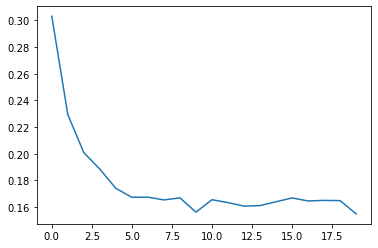

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown

plt.plot(binary_sce_model.history.history['val_loss'])

### Print the final results in big bold text

In [8]:
text = "The accuracy is {:4.3f}% for the test set and {:4.3f}% for the training set".format(
    binary_sce_model.history.history['val_accuracy'][-1]*100,
    binary_sce_model.history.history['accuracy'][-1]*100)
display(Markdown(f"# {text}"))

# The accuracy is 96.290% for the test set and 96.232% for the training set

In [9]:
text

'The accuracy is 96.290% for the test set and 96.232% for the training set'